In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt 
import datetime, pytz
from plotly import tools
from plotly.offline import init_notebook_mode, iplot
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import plotly
from sklearn.metrics import mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Activation
import keras
import tensorflow

In [4]:
# For colab users
path = '/content/drive/MyDrive/Classroom/2022년 KDB-SNU AI 비학위과정/과제_Bitcoin/'
#path = '/kaggle/input/bitcoin-historical-data/bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv'
filename = 'bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv'
df_raw = pd.read_csv(f'{path}{filename}')

In [ ]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4857377 entries, 0 to 4857376
Data columns (total 8 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Timestamp          int64  
 1   Open               float64
 2   High               float64
 3   Low                float64
 4   Close              float64
 5   Volume_(BTC)       float64
 6   Volume_(Currency)  float64
 7   Weighted_Price     float64
dtypes: float64(7), int64(1)
memory usage: 296.5 MB


In [ ]:
df_raw.shape[1]

8

In [5]:
df_raw['date'] = pd.to_datetime(df_raw['Timestamp'],unit='s').dt.date
df_group = df_raw.groupby('date')
Price = df_group['Close'].mean()

In [ ]:
plt.figure(figsize = (15,6))
# plt.plot(df.index, df['Close'], label = 'Close price')
plt.plot(Price, label = 'BTC Close Price')
plt.legend()
plt.grid()
plt.title('Bitcoin Close price')
plt.savefig('./bitcoin_close_price.png')
plt.show()

In [ ]:
df_price_zz=Price.to_frame()
df_price_zz['Timestamp'] = df_price_zz.index
df_price_zz['Timestamp'] = pd.to_datetime(df_price_zz['Timestamp'])
df_price_zz.reset_index(drop=True,inplace=True)
df_price_include_zz = df_price_zz[df_price_zz['Timestamp'].dt.year >= 2017]
df_price_include_zz.reset_index(drop=True,inplace=True)

In [ ]:
df_price_include_zz = df_price_include_zz[['Timestamp','Close']]

In [ ]:
df_price_include_zz.head()

In [ ]:
df_price_include_zz.set_index("Timestamp", inplace = True)
df_price_include_zz

In [ ]:
df_price_include_zz.shape[0]

1551

In [ ]:
Price.to_numpy()
df_price=Price.to_frame()
df_price['Timestamp'] = df_price.index
df_price['Timestamp'] = pd.to_datetime(df_price['Timestamp'])
df_price.reset_index(drop=True,inplace=True)
df_price_include = df_price[df_price['Timestamp'].dt.year >= 2017]
df_price_include.reset_index(drop=True,inplace=True)

In [ ]:
prediction_days = 50
df_train= df_price_include_zz[:len(df_price_include_zz)-prediction_days] #마지막 50일치 빼고 훈련 데이터로 세팅
df_test= df_price_include_zz[len(df_price_include_zz)-prediction_days:] #마지막 50일치를 Test Set으로 설정
df_train.tail(5)

In [ ]:
df_test.tail(5)

In [ ]:
df_test.head(5)

# XGBoost(Qoo)

In [6]:
from xgboost import XGBRegressor
import seaborn as sns
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
from itertools import cycle
import plotly.express as px

In [7]:
df_price_zz_all=Price.to_frame()
df_price_zz_all['Timestamp'] = df_price_zz_all.index
df_price_zz_all['Timestamp'] = pd.to_datetime(df_price_zz_all['Timestamp'])
df_price_zz_all.reset_index(drop=True,inplace=True)
df_price_include_xg = df_price_zz_all[df_price_zz_all['Timestamp'].dt.year >= 2017]
df_price_include_xg.reset_index(drop=True,inplace=True)
closedf = df_price_include_xg[['Timestamp','Close']]
print("Shape of close dataframe:", closedf.shape)

Shape of close dataframe: (1551, 2)


In [ ]:
closedf.head()

In [9]:
close_stock = closedf.copy()
print("Total data for prediction: ",closedf.shape[0])

Total data for prediction:  1551


In [10]:
#Normalizing close price value
del closedf['Timestamp']
scaler=MinMaxScaler(feature_range=(0,1))
closedf=scaler.fit_transform(np.array(closedf).reshape(-1,1))
print(closedf.shape)

(1551, 1)


In [11]:
test_size=int(len(closedf)*0.15)
training_size=len(closedf)-test_size
train_data,test_data=closedf[0:training_size,:],closedf[training_size:len(closedf),:1]
print("train_data: ", train_data.shape)
print("test_data: ", test_data.shape)

train_data:  (1319, 1)
test_data:  (232, 1)


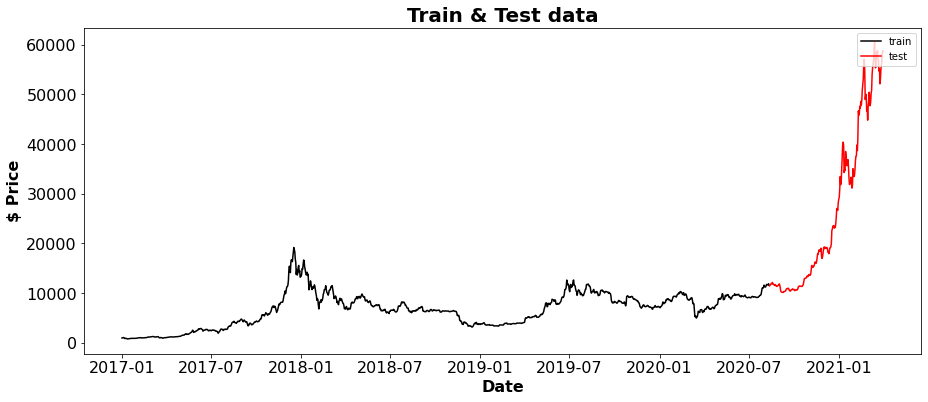

In [12]:

fig, ax = plt.subplots(figsize=(15, 6))
sns.lineplot(x = close_stock['Timestamp'][:len(train_data)], y = close_stock['Close'][:len(train_data)], color = 'black')
sns.lineplot(x = close_stock['Timestamp'][len(train_data):], y = close_stock['Close'][len(train_data):], color = 'red')

# Formatting
ax.set_title('Train & Test data', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Date', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('$ Price', fontsize = 16, fontdict=dict(weight='bold'))
plt.tick_params(axis='y', which='major', labelsize=16)
plt.tick_params(axis='x', which='major', labelsize=16)
plt.legend(loc='upper right' ,labels = ('train', 'test'))
plt.show()

In [13]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [14]:
time_step = 10
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

X_train:  (1308, 10)
y_train:  (1308,)
X_test:  (221, 10)
y_test (221,)


In [15]:
# Biulding Model
# Import XGBRegressor module and Fit X_train and y_train for training model

model5 = XGBRegressor(n_estimators=1000)
model5.fit(X_train, y_train, verbose=False)

[07:53:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(n_estimators=1000)

In [16]:

predictions = model5.predict(X_test)
print("Mean Absolute Error - MAE : " + str(mean_absolute_error(y_test, predictions)))
print("Root Mean squared Error - RMSE : " + str(math.sqrt(mean_squared_error(y_test, predictions))))

Mean Absolute Error - MAE : 0.19502561582501776
Root Mean squared Error - RMSE : 0.3069891126680655


In [17]:
train_predict=model5.predict(X_train)
test_predict=model5.predict(X_test)

train_predict = train_predict.reshape(-1,1)
test_predict = test_predict.reshape(-1,1)

print("Train data prediction:", train_predict.shape)
print("Test data prediction:", test_predict.shape)

Train data prediction: (1308, 1)
Test data prediction: (221, 1)


In [18]:
# Transform back to original form

train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1)) 
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1))

In [19]:
# shift train predictions for plotting

look_back=time_step
trainPredictPlot = np.empty_like(closedf)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)

# shift test predictions for plotting
testPredictPlot = np.empty_like(closedf)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(closedf)-1, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)

names = cycle(['Original close price','Train predicted close price','Test predicted close price'])

plotdf = pd.DataFrame({'date': close_stock['Timestamp'],
                       'Original_Price': close_stock['Close'],
                      'Train_predicted_Price': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'Test_predicted_Price': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['date'], y=[plotdf['Original_Price'],plotdf['Train_predicted_Price'],
                                          plotdf['Test_predicted_Price']],
              labels={'value':'Close price','date': 'Date'})
fig.update_layout(title_text='Comparision between original close price vs predicted close price',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

Train predicted data:  (1551, 1)
Test predicted data:  (1551, 1)
